# Zero-shot learning with diffusion models as prior

Goal is to use pretrained diffusion models to solve down stream tasks without further training.

Given an observation $y$, a degradation operator, and a standard deviation $\sigma_y$ on the observation, we will find $x$ that verifies
$$
y = \mathrm{A} x + \sigma_y \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathrm{I}).
$$

These problems are often ill-posed, in other terms, many solutions verify the equation without being consistent with measurement.
The Bayesian approach consistent in assuming a prior over $x$ and searching for a sample that better align with the measurement.
Formally, solving the problem amounts to posterior sampling.

In the following, we will assume we have access to a pretrained diffusion model (our prior) and we will solve instance of the inverse problem that arise in image restoration tasks.

In [1]:
import torch
from tqdm import tqdm

device = "cuda:0"
torch.manual_seed(1235)

## Exploring the prior

Let us load a diffusion model trained on CelebaHQ dataset.
If not available, the model will be downloaded automatically.

In [2]:
# let load the model from Hugging face
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256").to(device)


/data/badr.moufad/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


To check we loaded the model, let's generate one image.
The pipeline object has a built-in call function to generate image and simulate internally the reverse markov process.

In [ ]:
out = pipeline()

out.images[0]

The main principal to solve inverse problems with diffusion models is to alter the reverse process in a way to skew it towards regions of the prior that are consistent with the measurement.

For that, let's isolate each component, namely
- the noise predictor
- the noise scheduler $\{ \bar{\alpha}_t \}_t$ (``alphas_cumprod``)

and then implement a wrapper to expose them.

The quantity $\mathbb{E}[X_0 | X_t = x_t]$, also called the denoiser, is ubiquitous when solving inverse problem.
Hence, let us endow the wrapper with a method ``predict_x0`` to compute it.

Recall that the noise predictor and the denoiser are linked through

$$
\mathbb{E}[X_0 | X_t = x_t] = \frac{1}{\sqrt{\bar{\alpha}_t}} \big( x_t - \sqrt{1 - \bar{\alpha}_t} \epsilon_{\theta}(x_t, t) \big)
$$

Notice that we endow the wrapper with a ``set_timesteps`` method to use DDIM sampling.

In [3]:
# wrapper
class EpsilonNetWrapper(torch.nn.Module):

    def __init__(self, model, alphas_cumprod, device="cpu"):
        super().__init__()

        self.model = model
        self.alphas_cumprod = alphas_cumprod
        self.timesteps = torch.arange(len(alphas_cumprod), device=device)
        self.device = device

    def set_timesteps(self, n_steps):
        steps = len(self.alphas_cumprod) // n_steps
        self.timesteps = torch.arange(0, len(self.alphas_cumprod), steps, device=self.device)

    def forward(self, x_t, t):
        return self.model(x_t, t).sample

    def predict_x0(self, x_t, t):
        acp_t = self.alphas_cumprod[t]

        pred_noise = self(x_t, t)
        return (x_t - (1 - acp_t).sqrt() * pred_noise) / acp_t.sqrt()


Let's extract the component needed from the pipeline.

In [ ]:
# extract the noise predictor
model = pipeline.unet

# set the denoiser to inference mode
model = model.requires_grad_(False)
model = model.eval()

# extract the alphas_cumprod
alphas_cumprod = pipeline.scheduler.alphas_cumprod
alphas_cumprod = alphas_cumprod.to(device)

# init eps_net
eps_net = EpsilonNetWrapper(model, alphas_cumprod, device=device)

Let's generate an image using our wrapper

In [4]:
from assets.py_code.diffusion import ddim_statistics

eps_net.set_timesteps(200)

timesteps = eps_net.timesteps
reversed_timesteps = timesteps.flip(0)

x_t = torch.randn((1, 3, 256, 256), device=device)
for t, t_prev in tqdm(zip(reversed_timesteps[:-1], reversed_timesteps[1:])):

    # denoise
    x_0t = eps_net.predict_x0(x_t, t)

    # get DDIM coefficients
    coef_x_t, coef_x_0, std = ddim_statistics(t, t_prev, eps_net.alphas_cumprod)

    # compute x_t_prev
    noise = torch.randn_like(x_t, device=device)
    x_t = coef_x_t * x_t + coef_x_0 * x_0t + std * noise

x_t = x_t.clamp(-1, 1)

199it [00:08, 22.72it/s]


Question: why we clamped the image to a ``[-1, 1]`` range ?

To plot the $x_t$, we will use the function ``display_img_tensor`` available in the provided code.

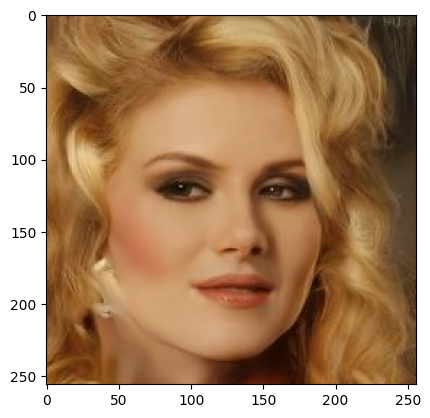

In [5]:
from assets.py_code.diffusion import display_img_tensor

display_img_tensor(x_t)

Let us explore what happens during the reverse process.
For that monitor the two quantities
- the latent $x_t$
- the the denoised image $\mathbb{E}[X_0 | X_t = x_t]$

199it [00:08, 23.43it/s]


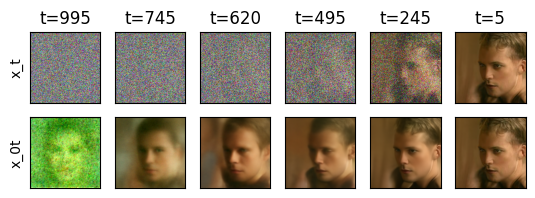

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from assets.py_code.diffusion import ddim_statistics

eps_net.set_timesteps(200)

timesteps = eps_net.timesteps
reversed_timesteps = timesteps.flip(0)

selected_timesteps = reversed_timesteps[[0, 50, 75, 100, 150, -2]]
fig, axes = plt.subplots(2, len(selected_timesteps), sharey=True)

# plot x_t in the first row and x_0t in the second row
axes[0, 0].set_ylabel("x_t")
axes[1, 0].set_ylabel("x_0t")


counter = 0
x_t = torch.randn((1, 3, 256, 256), device=device)
for t, t_prev in tqdm(zip(reversed_timesteps[:-1], reversed_timesteps[1:])):

    # denoise
    x_0t = eps_net.predict_x0(x_t, t)

    # get DDIM coefficients
    coef_x_t, coef_x_0, std = ddim_statistics(t, t_prev, eps_net.alphas_cumprod)

    # compute x_t_prev
    noise = torch.randn_like(x_t, device=device)
    x_t = coef_x_t * x_t + coef_x_0 * x_0t + std * noise

    if t in selected_timesteps:
        ax = axes[0, counter]
        ax.set_title(f"t={t.item()}")
        ax.set_xticks([]); ax.set_yticks([]);

        # plot x_t
        display_img_tensor(x_t.clamp(-1, 1), ax)

        # plot x_0t
        ax = axes[1, counter]
        display_img_tensor(x_0t.clamp(-1, 1), ax)
        ax.set_xticks([]); ax.set_yticks([]);

        counter += 1

fig.subplots_adjust(hspace=-0.7)


## Degradadation operator

Here, we will emulate a linear inverse problem.

1. we will load a degradation operator
2. we will apply it on an image taken from CelebaHQ dataset

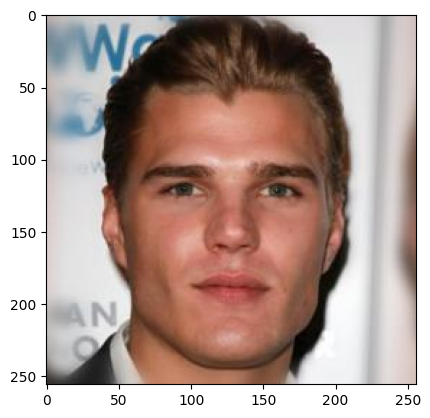

In [8]:
# load image and displaying it
from assets.py_code.imaging import load_image, display_img_tensor

x_origin = load_image("./assets/images/00010.jpg", device)

display_img_tensor(x_origin)

In [9]:
from assets.py_code.inv_problems import Colorization, BoxInpainting

degradation_operators = {
    "inpainting": BoxInpainting(device=device),
    "colorization": Colorization(img_dim=256, device=device)
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


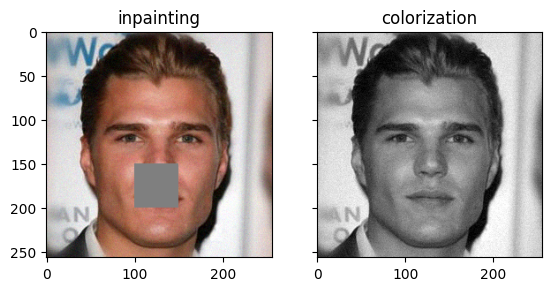

In [10]:
# plot degradations
std_y = 0.05

fig, axes = plt.subplots(1, 2, sharey=True)

for ax, (name, operator) in zip(axes, degradation_operators.items()):

    # apply the operator
    y = operator.H(x_origin[None])
    y = y + std_y * torch.randn_like(y, device=device)

    # get the observation
    obs = operator.H_pinv(y)
    obs = obs.reshape(*x_origin.shape)

    ax.set_title(name)
    display_img_tensor(obs, ax)

## Solving inverse problems with DPS

Let us solve the two problems using DPS algorithm [1].

Notice the reverse step in algorithm resemble the one of DDIM with the exception of adding a gradient term in the line 7 with magnitude $\zeta$.

<img src="./illustrations/dps_algo.png" width="350px">


.. [1] Chung, Hyungjin, et al.
    "Diffusion posterior sampling for general noisy inverse problems."
    arXiv preprint arXiv:2209.14687 (2022)

In [11]:
# Implement DPS algorithm
def dps(
        initial_noise: torch.Tensor,
        y, operator,
        eps_net: EpsilonNetWrapper,
        gamma: float = 1.0
):
    reversed_timesteps = eps_net.timesteps.flip(0)

    x_t = initial_noise
    for t, t_prev in tqdm(zip(reversed_timesteps[:-1], reversed_timesteps[1:])):

        coef_x_t, coef_x_0, std = ddim_statistics(t, t_prev, eps_net.alphas_cumprod)

        # compute guidance term
        x_t.requires_grad_(True)
        x_0t = eps_net.predict_x0(x_t, t)
        loss = torch.norm(y - operator.H(x_0t))
        loss.backward()

        # compute the update
        with torch.no_grad():
            normalized_grad = x_t.grad
            noise = torch.randn_like(x_t)

            x_t = coef_x_t * x_t + coef_x_0 * x_0t + std * noise
            x_t = x_t - gamma * normalized_grad

    return x_t

### Inpainting problem

Inpainting is an inverse problem where the goal is to fill in missing part of a signal.

Let's solve an instance of such problem.

In [12]:
# create the problem
operator = degradation_operators["inpainting"]

# generate inverse problem
y = operator.H(x_origin[None])
y = y + std_y * torch.randn_like(y, device=device)

initial_noise = torch.randn((1, 3, 256, 256), device=device)

199it [00:17, 11.18it/s]


In [ ]:
# solve the problem using DPS
reconstruction = dps(initial_noise, y, operator, eps_net, gamma=1.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


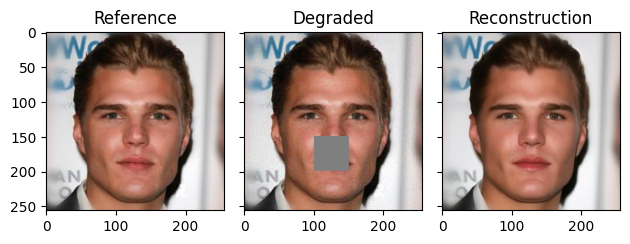

In [14]:
# let's view the result
obs = operator.H_pinv(y)
obs = obs.reshape(*x_origin.shape)

# init figure
fig, axes = plt.subplots(1, 3, sharey=True)

images = (x_origin, obs, reconstruction)
titles = ("Reference", "Degraded", "Reconstruction")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_img_tensor(img, ax)
    ax.set_title(title)

fig.tight_layout()

### Solve colorization problem

In colorization problem, we observe a gray-scale image and aim endow it with colors, convert it into RGB image

Let's solve an instance of such problem.

In [17]:
operator = degradation_operators["colorization"]

# generate inverse problem
y = operator.H(x_origin[None])
y = y + std_y * torch.randn_like(y, device=device)

initial_noise = torch.randn((1, 3, 256, 256), device=device)
reconstruction = dps(initial_noise, y, operator, eps_net, gamma=1.0)

0it [00:00, ?it/s]

199it [00:16, 11.72it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


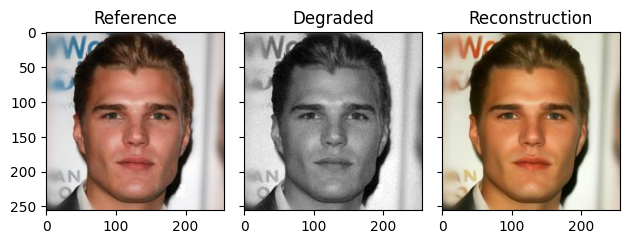

In [18]:
obs = operator.H_pinv(y)
obs = obs.reshape(*x_origin.shape)


# init figure
fig, axes = plt.subplots(1, 3, sharey=True)

images = (x_origin, obs, reconstruction)
titles = ("Reference", "Degraded", "Reconstruction")

# display figures
for ax, img, title in zip(axes, images,titles):
    display_img_tensor(img, ax)
    ax.set_title(title)

fig.tight_layout()

To demystify what happening inside, let us plot again
- the latent $x_t$
- the the denoised image $\mathbb{E}[X_0 | X_t = x_t]$

199it [00:15, 12.73it/s]


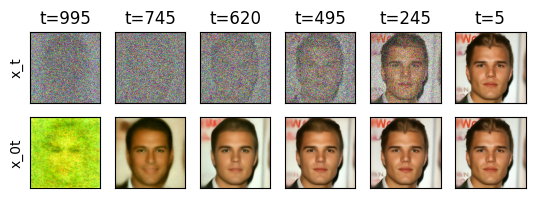

In [20]:
reversed_timesteps = eps_net.timesteps.flip(0)

selected_timesteps = reversed_timesteps[[0, 50, 75, 100, 150, -2]]
fig, axes = plt.subplots(2, len(selected_timesteps), sharey=True)

# plot x_t in the first row and x_0t in the second row
axes[0, 0].set_ylabel("x_t")
axes[1, 0].set_ylabel("x_0t")


counter = 0
gamma = 1.0
x_t = initial_noise
for t, t_prev in tqdm(zip(reversed_timesteps[:-1], reversed_timesteps[1:])):

    coef_x_t, coef_x_0, std = ddim_statistics(t, t_prev, eps_net.alphas_cumprod)

    # compute guidance term
    x_t.requires_grad_(True)
    x_0t = eps_net.predict_x0(x_t, t)
    loss = torch.norm(y - operator.H(x_0t))
    loss.backward()

    # compute the update
    with torch.no_grad():
        normalized_grad = x_t.grad
        noise = torch.randn_like(x_t)

        x_t = coef_x_t * x_t + coef_x_0 * x_0t + std * noise
        x_t = x_t - gamma * normalized_grad

        # plot evolution
        if t in selected_timesteps:
            ax = axes[0, counter]
            ax.set_title(f"t={t.item()}")
            ax.set_xticks([]); ax.set_yticks([]);

            # plot x_t
            display_img_tensor(x_t.clamp(-1, 1), ax)

            # plot x_0t
            ax = axes[1, counter]
            display_img_tensor(x_0t.clamp(-1, 1), ax)
            ax.set_xticks([]); ax.set_yticks([]);

            counter += 1

fig.subplots_adjust(hspace=-0.7)

Now it is you turn to solve Super Resolution problem.

In Super Resolution, the goal is to increase the resolution (amount of details) in an image.
Implicitly, it means to add pixels to the image.

For that,

1. Load image ``00019.jpg``
2. load Super Resolution ``SR4`` operator (it is available in ``py_code.inv_problems`` module)
3. generate the inverse problem
4. solve the inverse problem using DPS